In [248]:
import numpy as np
import math
import GPy
import matplotlib.pyplot as plt
import seaborn

In [249]:
import numpy as np
from scipy.stats import qmc

# Goldstein-Price function (as defined in previous responses)
def goldstein_price(data):
    x = data[0]
    y = data[1]
    val1 = (1 + (x+y+1)**2 * (19-14*x+3*x**2-14*y+6*x*y+3*y**2))
    val2 = (30 + ((2*x-3*y)**2) * (18-32*x+12*x**2+48*y-36*x*y+27*y**2))
    return math.log10(val1 * val2)


d = 2 

# Number of samples
n_samples = 32

# Create a Sobol sequence generator
sobol_engine = qmc.Sobol(d=d, scramble=False)  # scramble=True for better properties in high dimensions

# Generate Sobol points
sobol_points = sobol_engine.random_base2(m=int(np.log2(n_samples)))


# If n_samples is not a power of 2: (important!)
if not (n_samples != 0 and (n_samples & (n_samples - 1) == 0)): # Check if n_samples is not a power of 2
    sobol_points = sobol_engine.random(n=n_samples) #use random if not power of two


# Scale and shift to the Goldstein-Price domain [-2, 2]
domain_min = -2
domain_max = 2
scaled_sobol_points = domain_min + (domain_max - domain_min) * sobol_points
# Evaluate the function
function_values = np.array([goldstein_price(point) for point in scaled_sobol_points])

In [250]:
def best_kernel_search(X, y):
    
    kernel = GPy.kern.StdPeriodic(input_dim=X.shape[1], variance = 1.0, lengthscale= 1.0) + GPy.kern.RBF(input_dim=X.shape[1], variance=1.0, lengthscale=1.0)
    mean = GPy.mappings.Constant(input_dim = X.shape[1], output_dim = 1, value = 0)
    model = GPy.models.GPRegression(X, y, kernel, noise_var=0.001**2, mean_function=mean)
    model.Gaussian_noise.variance.fix()
    model.optimize_restarts(100, verbose=False)

    n = model.num_data
    k = len(model.optimizer_array)
    log_likelihood = model.log_likelihood()
    
    bic = k * np.log(n) - 2 * log_likelihood
    print(bic)
    print(model)

    return model

In [251]:
def fit_gaussian_gpy(X, y):
    k = GPy.kern.RBF(input_dim=X.shape[1], variance=1.0, lengthscale=1.0)  
    mean = GPy.mappings.Constant(input_dim = X.shape[1], output_dim = 1, value = 0)
    model = GPy.models.GPRegression(X, y, k, noise_var=0.001**2, mean_function=mean)

    model.Gaussian_noise.variance.fix()
    #model.kern.lengthscale.constrain_bounded(1e-15, 1e15)
    #model.kern.variance.constrain_bounded(1e-20, 1e20)  # Constrain variance of RBF

    model.optimize_restarts(100, verbose=False)  

    print(model)  
    n = model.num_data
    k = len(model.parameters)
    log_likelihood = model.log_likelihood()
    
    bic = k * np.log(n) - 2 * log_likelihood

    return model

In [252]:
store = best_kernel_search(scaled_sobol_points, function_values.reshape(-1, 1))

 /Users/anthonychiang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/GPy/kern/src/standard_periodic.py:130: RuntimeWarning:overflow encountered in divide
 /Users/anthonychiang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/GPy/kern/src/standard_periodic.py:131: RuntimeWarning:invalid value encountered in sin
 /Users/anthonychiang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/GPy/kern/src/standard_periodic.py:506: RuntimeWarning:overflow encountered in divide
 /Users/anthonychiang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/GPy/kern/src/standard_periodic.py:508: RuntimeWarning:invalid value encountered in sin
 /Users/anthonychiang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/GPy/kern/src/standard_periodic.py:511: RuntimeWarning:invalid value encountered in cos
 /Users/anthonychiang/.pyenv/versions/3.11.5/lib/python3.11/site-packages/GPy/kern/src/standard_periodic.py:511: RuntimeWarning:overflow encountered in divide
 /Users/anthonychiang/.pyenv/versions/3.

73.1960504370535

Name : GP regression
Objective : 26.20081751012757
Number of Parameters : 7
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |                value  |  constraints  |  priors
  constmap.C                    |    4.631168538526043  |               |        
  sum.std_periodic.variance     |  0.27503674103173226  |      +ve      |        
  sum.std_periodic.period       |   0.1980464823696228  |      +ve      |        
  sum.std_periodic.lengthscale  |  0.39405913185985236  |      +ve      |        
  sum.rbf.variance              |   1.1217820095168345  |      +ve      |        
  sum.rbf.lengthscale           |    1.317886882950203  |      +ve      |        
  Gaussian_noise.variance       |                1e-06  |   +ve fixed   |        


In [254]:
x1_grid = np.linspace(-2, 2, 1000)
x2_grid = np.linspace(-2, 2, 1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
X_grid = np.vstack((X1.ravel(), X2.ravel())).T  # Reshape into a 2D array (1000000, 2)
# Make predictions (posterior mean and variance) on the grid
y_pred, y_var = store.predict(X_grid)
y_std = np.sqrt(y_var)
# Reshape the predictions back to the grid shape
y_pred_grid = y_pred.reshape(1000, 1000)

In [255]:
from scipy.stats import norm

In [256]:
prob = np.min(function_values).reshape(1, 1)- y_pred
prob_imp = prob / y_std
ans = ((norm.cdf(prob_imp) * prob_imp) + norm.pdf(prob_imp)) * y_std

In [257]:
EI = ans.reshape(1000, 1000)
ind = np.unravel_index(np.argmax(EI, axis=None), EI.shape)

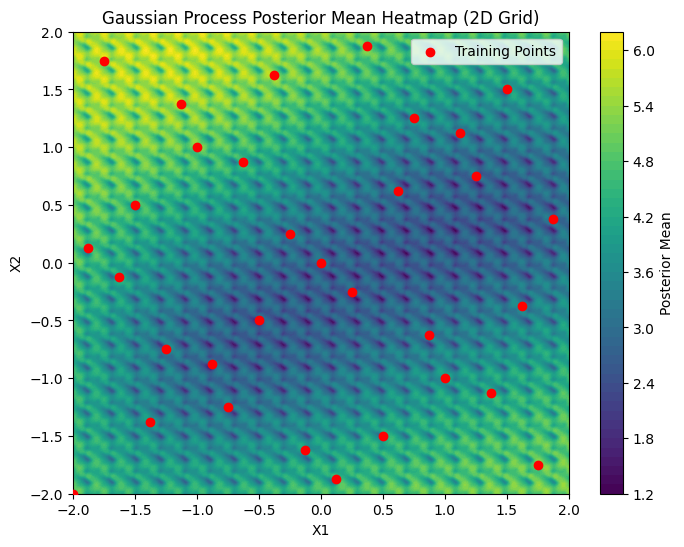

In [258]:
y_pred_grid = y_pred.reshape(1000, 1000)

# Plot the posterior mean as a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, y_pred_grid, 50, cmap="viridis")
plt.colorbar(label='Posterior Mean')
plt.scatter(scaled_sobol_points[:, 0], scaled_sobol_points[:, 1], color='red', zorder=10, label='Training Points')
plt.title("Gaussian Process Posterior Mean Heatmap (2D Grid)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

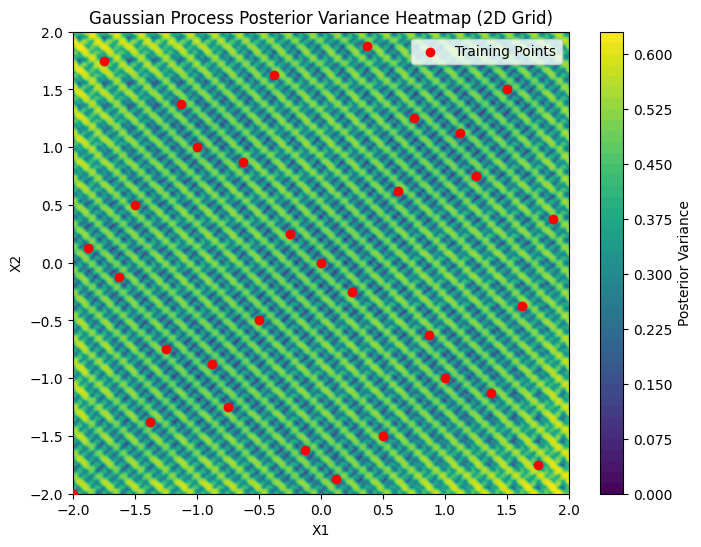

In [259]:
y_std_grid = y_std.reshape(1000, 1000)
# Plot the posterior mean as a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, y_std_grid, 50, cmap="viridis")
plt.colorbar(label='Posterior Variance')
plt.scatter(scaled_sobol_points[:, 0], scaled_sobol_points[:, 1], color='red', zorder=10, label='Training Points')
plt.title("Gaussian Process Posterior Variance Heatmap (2D Grid)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

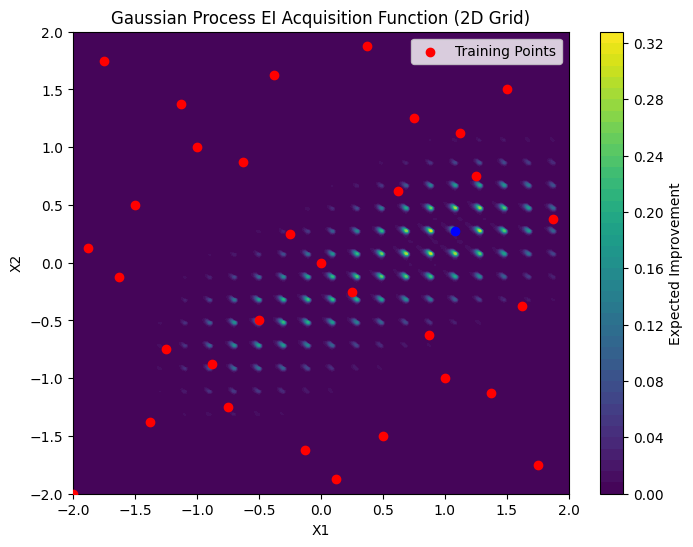

In [260]:
plt.figure(figsize=(8, 6))
plt.contourf(X1, X2, EI, 50, cmap="viridis")
plt.colorbar(label='Expected Improvement')
plt.scatter(x2_grid[ind[1]], x1_grid[ind[0]], color = "blue", zorder = 9)
plt.scatter(scaled_sobol_points[:, 0], scaled_sobol_points[:, 1], color='red', zorder=10, label='Training Points')
plt.title("Gaussian Process EI Acquisition Function (2D Grid)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()
